In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import GenerateEMRIWaveform, FastSchwarzschildEccentricFlux, FastKerrEccentricEquatorialFlux
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable
from tqdm import tqdm

#try:
#    import cupy as cp
#    use_gpu = True
#except ImportError():
#    print("Not on GPU")
#    use_gpu = False

use_gpu = False

from stableemrifisher.fisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
    force_backend = 'cpu'
else:
    force_backend = 'gpu'
    pass #let the backend decide for itself.

startup


/home/shubham/miniconda3/envs/SKeqfull/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
#waveform class setup
waveform_class = FastSchwarzschildEccentricFlux
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

T = 0.1
dt = 10.0

In [4]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                      stats_for_nerds = True, use_gpu = use_gpu,
                       T=T, dt=dt,
                      deriv_type='stable')

No noise model or response wrapper provided.
Defaulting to the sky-averaged sensitivity curve


Body is not plunging, Fisher should be stable.
wave ndim: 2
Computing SNR for parameters: (1000000.0, 10.0, 0.0, 9.5, 0.4, 1.0, 0.1, 1.0471975511965976, 0.7853981633974483, 0.5235987755982988, 0.39269908169872414, 1.0, 0.0, 0.0)
Waveform Generated. SNR: 149.444049566199
calculating stable deltas...
Gamma_ii for e0: 46779195348177.68
Gamma_ii for e0: 46779119870341.68
Gamma_ii for e0: 46779516710458.36
Gamma_ii for e0: 46778290334594.586
Gamma_ii for e0: 46777931277315.83
Gamma_ii for e0: 46779773451652.016
Gamma_ii for e0: 46827798944280.695
Gamma_ii for e0: 46929769021667.12
[np.float64(1.6134941445927787e-06), np.float64(8.483202576373926e-06), np.float64(2.6216773956496633e-05), np.float64(7.675783621750954e-06), np.float64(3.9379719059380015e-05), np.float64(0.0010255765530603755), np.float64(0.002172822912027184)]
0


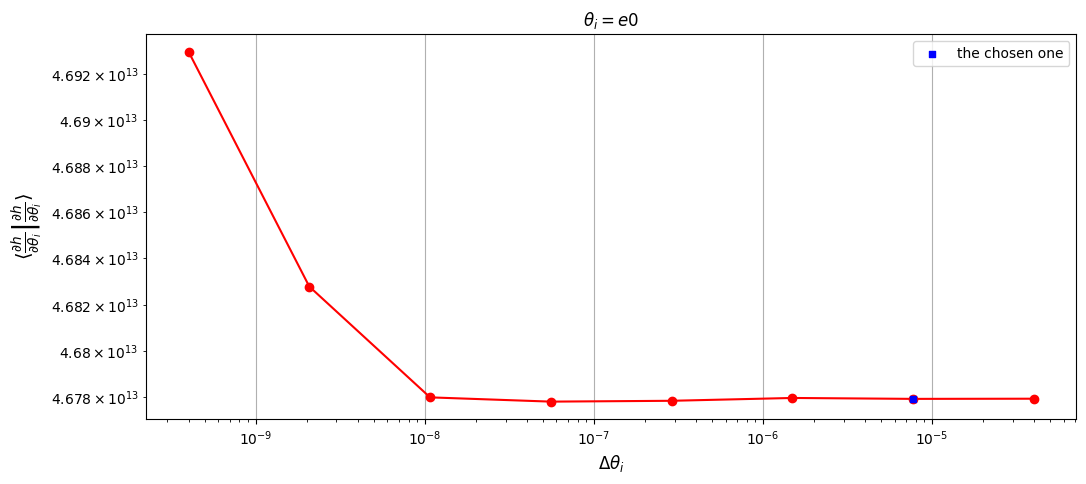

stable deltas: {'e0': 7.722790915533e-06}
Time taken to compute stable deltas is 39.622267961502075 seconds
calculating Fisher matrix...
Finished derivatives
Calculated Fisher is *atleast* positive-definite.
Time taken to compute FM is 3.9663450717926025 seconds


In [5]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.1
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = 1.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
wave_params = dict(
    m1=m1,
    m2=m2,
    a=a,
    p0=p0,
    e0=e0,
    xI0=xI0,
    dist=dist,
    qS=qS,
    phiS=phiS,
    qK=qK,
    phiK=phiK,
    Phi_phi0=Phi_phi0,
    Phi_theta0=Phi_theta0,
    Phi_r0=Phi_r0
)
param_names = ['e0']

der_order = 4
Ndelta = 8
stability_plot = True

#delta_range = dict(
#    m1 = np.geomspace(1e-4*m1, 1e-9*m1, Ndelta),
#    m2 = np.geomspace(1e-4*m2, 1e-9*m2, Ndelta),
#    p0 = np.geomspace(1e-4*p0, 1e-9*p0, Ndelta),
#    e0 = np.geomspace(1e-4*e0, 1e-9*e0, Ndelta),
#)

Fisher = sef(wave_params=wave_params, param_names = param_names, 
             der_order = der_order, 
             Ndelta = Ndelta, 
             stability_plot = stability_plot,
             #delta_range = delta_range,
             live_dangerously = False)

In [6]:
if sef.deriv_type == 'stable': 
    if not sef.has_ResponseWrapper:
        Npad = sef.derivative.cache['Npad'] if sef.derivative.cache['Npad'] > 0 else 1
    else:
        Npad = sef.derivative.waveform_gen.cache['Npad'] if sef.derivative.waveform_gen.cache['Npad'] > 0 else 1
else:
    Npad = 1
    
print(Npad)

1


In [7]:
wave_gen_base = waveform_generator(waveform_class=waveform_class,
                                   **sef.waveform_generator_kwargs)

In [8]:
if use_gpu:
    import cupy as cp
    xp = cp
else:
    xp = np
    
wave = xp.asarray([xp.concatenate((sef.waveform[i][:-Npad], xp.zeros(Npad)), dtype = sef.waveform.dtype) for i in range(len(sef.waveform))])

if use_gpu:
    wave = wave.get()

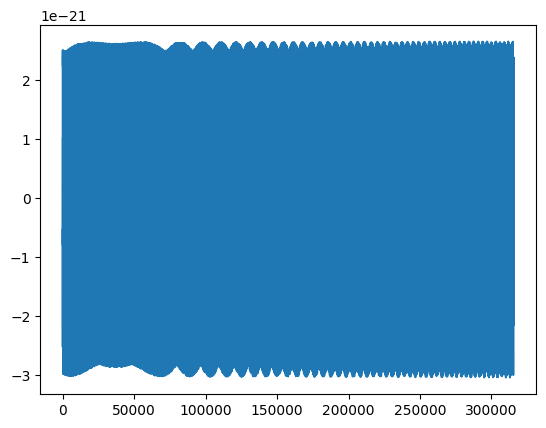

In [9]:
plt.plot(wave[0])

In [10]:
def Fisher_1D(partialh):
    return inner_product(partialh, partialh, PSD = PSD, dt = dt, use_gpu=use_gpu)

sigma1D = 1/np.sqrt(Fisher[0,0])
print(f"sigma", sigma1D)
PSD = sef.PSD_funcs

def likelihood(h_inj, h_temp):
    if len(h_inj) == 1:
        delta = h_inj - h_temp
        delta = [delta.real, -delta.imag]
    else:
        delta = [h_inj[i] - h_temp[i] for i in range(len(h_inj))]
        
    return np.exp(-0.5 * inner_product(delta, delta, PSD = PSD, dt = dt, use_gpu=use_gpu))

N = 50

param_to_vary_range = np.linspace(sef.wave_params[param_names[0]] - 4 * sigma1D, sef.wave_params[param_names[0]] + 4 * sigma1D, N)

likes = []

for i in tqdm(range(N)):
    parameters_in = sef.wave_params.copy()
    parameters_in[param_names[0]] = param_to_vary_range[i]
    htemp = wave_gen_base(
        parameters_in['m1'],
        parameters_in['m2'],
        parameters_in['a'],
        parameters_in['p0'],
        parameters_in['e0'],
        parameters_in['xI0'],
        parameters_in['dist'],
        parameters_in['qS'],
        parameters_in['phiS'],
        parameters_in['qK'],
        parameters_in['phiK'],
        Phi_phi0 = parameters_in['Phi_phi0'],
        Phi_theta0 = parameters_in['Phi_theta0'],
        Phi_r0 = parameters_in['Phi_r0'],
        dt=dt, 
        T=T,
    )

    htemp = xp.concatenate((htemp[:-Npad], xp.zeros(Npad)), dtype = htemp.dtype)

    htemp = xp.asarray([htemp.real, -htemp.imag])

    #plt.plot(htemp.get()[0])
    #plt.plot(wave.get()[0], '--')
    #plt.show()
    
    likes.append(likelihood(wave, htemp))

sigma 1.462089562365674e-07


100%|███████████████████████████████████████████| 50/50 [01:44<00:00,  2.10s/it]


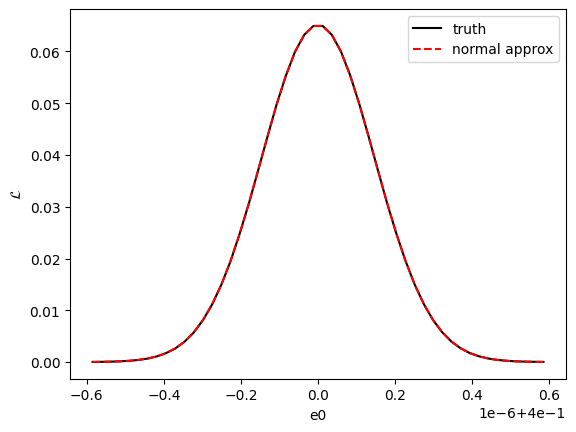

In [11]:
from scipy.stats import norm

normal_approx = norm.pdf(param_to_vary_range, loc = sef.wave_params[param_names[0]], scale = sigma1D)
normal_approx /= np.sum(normal_approx)
plt.plot(param_to_vary_range, likes/np.sum(likes), c='k', label='truth')
plt.plot(param_to_vary_range, normal_approx, c='r', label='normal approx', linestyle='--')
plt.legend()
plt.ylabel(r'$\mathcal{L}$')
plt.xlabel(param_names[0])
#plt.savefig(f'1D_like_vs_NA_{param_names[0]}.png', dpi = 300, bbox_inches='tight')
plt.show()